# MODEL FRUIT METABOLISM (non FVA version)

### Import model

In [1]:
from cobra import io, flux_analysis, util
from cobra.core import Metabolite, Reaction
import numpy as np
from studyFunctions import *
%matplotlib inline

In [2]:
cobra_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/ConstrainedFruitModel.xml")
if "cplex" in util.solvers.keys():
    cobra_model2.solver = "cplex"
else:
    cobra_model2.solver = "glpk"

List2edit = list()
for met in cobra_model2.metabolites:
    if met.id.endswith("_None"):
        List2edit.append(met)

for met in List2edit:
    met.id = met.id.replace("_None","")

cobra_model2.metabolites._generate_index()

weightings = dict()
for rxn in cobra_model2.reactions:
    weightings[rxn.id]=1

for k in ['ILE', '4_AMINO_BUTYRATE', 'GLN', 'GLC', 'GLY', 'CIT', 'GLT', 'FUM', 'SER', 'LYS', 'PRO', 'L_ASPARTATE',
          'ASN', 'L_ALPHA_ALANINE', 'VAL', 'STARCH', 'THR', 'SUCROSE', 'FRU', 'TRP', 'PHE', 'MET', 'MAL', 'TYR']:
    for i in range(1,10):
        if k != "STARCH":
            weightings[k+"_signal"+str(i)]=0

solution2 = pfba_Weighted(cobra_model2,weightings)

### Osmoles

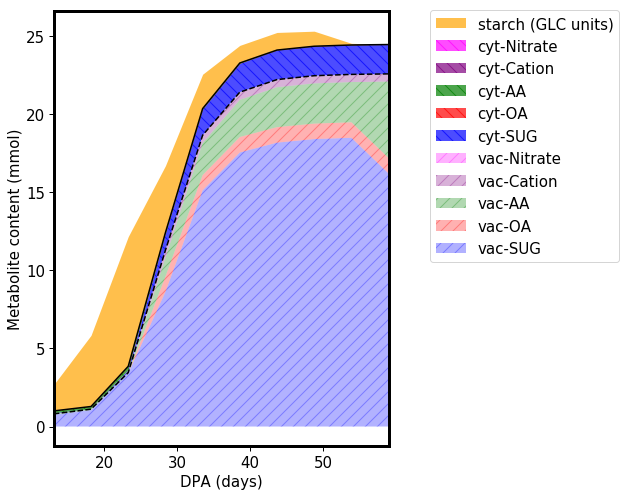

In [3]:
SOL = solution2

plotOsmoticContent(cobra_model2,SOL)

### Phytol and Lycopene constraints added

In [4]:
temp_model = cobra_model2.copy()
unit_time = 5.1

#Day time points of interest
DPA = list(np.linspace(8,59,11))
for i in range(0,len(DPA)):
    DPA[i]=round(DPA[i],1)

for i in range(1,11):
    rxn = temp_model.reactions.get_by_id("Lycopene_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn.upper_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn = temp_model.reactions.get_by_id("Phytol_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    rxn.upper_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day

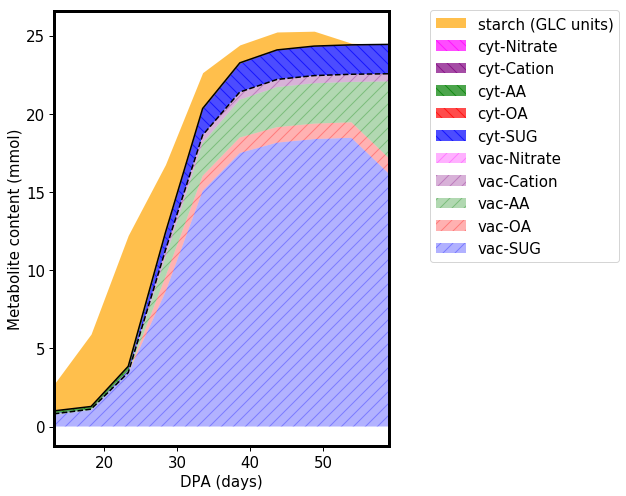

In [5]:
SOLtemp = pfba_Weighted(temp_model,weightings)
SOL = SOLtemp

plotOsmoticContent(cobra_model2,SOL)

In [6]:
SOL.fluxes["Final_Biomass_tx"]

1.1026173081545576

### Phloem uptake constraint removed

In [7]:
temp_model2 = temp_model.copy()
for i in range(1,11):
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0

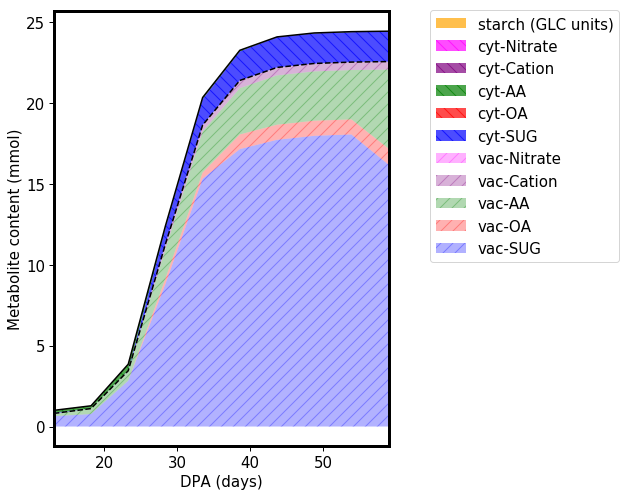

In [8]:
SOL = pfba_Weighted(temp_model2,weightings)

plotOsmoticContent(cobra_model2,SOL)

### Phloem uptake and osmolarity constraint removed

In [9]:
temp_model3 = temp_model2.copy()
for i in range(1,11):
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    temp_model3.metabolites.get_by_id("VO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_v"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_c"+str(i)).remove_from_model()

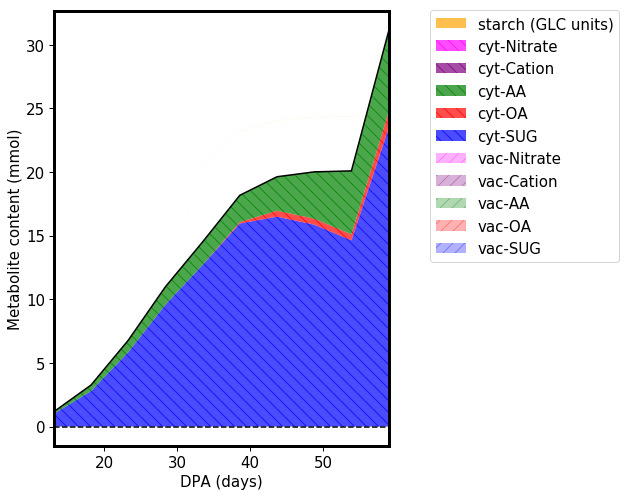

In [10]:
SOL = pfba_Weighted(temp_model3,weightings)

plotOsmoticContent(cobra_model2,SOL)

### Removing biomass constraints

In [11]:
temp_model4 = temp_model3.copy()
for i in range(1,11):
    rxn = temp_model3.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model4.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model4.metabolites.get_by_id(Met+str(i))
        rxn = temp_model4.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model4,weightings)

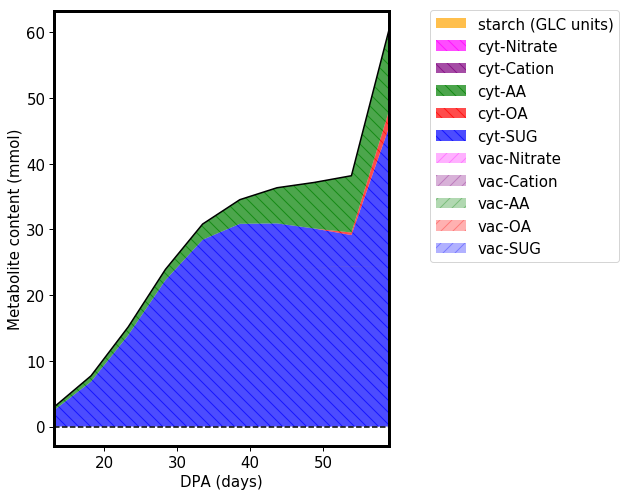

In [12]:
plotOsmoticContent(cobra_model2,SOL)

### Removing biomass constraints in system with osmotic constraints

In [13]:
temp_model5 = temp_model2.copy()
for i in range(1,11):
    rxn = temp_model2.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model5.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model5.metabolites.get_by_id(Met+str(i))
        rxn = temp_model5.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model5,weightings)

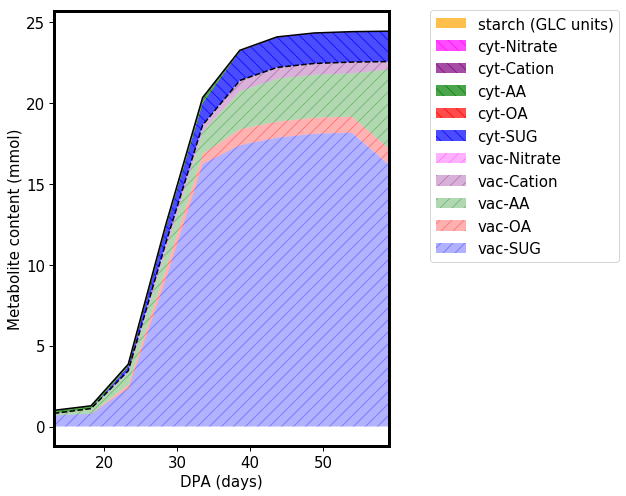

In [14]:
plotOsmoticContent(cobra_model2,SOL)